## Package Imports and Set-Ups

In [92]:
import re
import numpy as np
import pandas as pd
from wordfreq import zipf_frequency
from convokit import Corpus, download
from tqdm import tqdm
import matplotlib.pyplot as plt

# set up nltk tokenizers
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nickvick/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Helper Functions

In [93]:
def tokenize(text):
    '''Helper function to tokenize social media text. Note that the TweetTokenizer 
    preserves mentions, contractions'''
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)

    return tokens

In [94]:
def clean_lexical_tokens(tokens):
    '''Helper function to clean tokens by removing punctuation, numbers, and emojis
    for purely lexical analysis.'''

    cleaned = []

    for tok in tokens:
        # skip over punctuation
        if re.match(r'^\W+$', tok):
            continue
        # skip over emojis
        # if tok.encode()
        # only keep alphabetic tokens
        if tok.isalpha():
            cleaned.append(tok.lower())

    return cleaned

## Lexical Analysis Functions

In [95]:
def ttr(text):
    '''Function that returns the type-token ratio'''

    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)

    # error handling for when there are no tokens
    if len(tokens) == 0:
        return 0.0
    
    # recall that TTR is number of unique words / number of words
    num_types = len(set(tokens))
    num_tokens = len(tokens)
    ttr = num_types / num_tokens

    return ttr

In [96]:
def avg_word_length(text):
    '''Function that determines the average word length of a given text'''
    
    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)

    # error handling for when there are no tokens
    if len(tokens) == 0:
        return 0.0
    
    average_length = np.mean([len(word) for word in tokens])

    return average_length

In [97]:
# build aoa_dict: word -> average age of acquisition
aoa_df = pd.read_csv("Data/KupermanAoAData.csv")
aoa_dict = dict(zip(aoa_df["word"], aoa_df["rating_mean"]))

def aoa_score(text, aoa_dict):
    '''Returns the average age of acquisition score for a given text'''
    
    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)
    aoa_values = [aoa_dict[word] for word in tokens if word in aoa_dict]

    # if there are no words, return a default value
    if len(aoa_values) == 0:
        return np.nan
    
    aoa_score = np.mean(aoa_values)

    return aoa_score

In [98]:
def zipf_score(text):
    '''Returns a frequency score (higher -> more frequent) based on the Zipf scale'''
    
    tokens = tokenize(text)
    tokens = clean_lexical_tokens(tokens)
    
    zipf_values = [zipf_frequency(word, 'en') for word in tokens]

     # if there are no words, return a default value
    if len(zipf_values) == 0:
        return np.nan

    zipf_score = np.mean(zipf_values)

    return zipf_score

## Loading the Data

In [99]:
corpus = Corpus(filename=download("subreddit-Cornell"))

Dataset already exists at /Users/nickvick/.convokit/saved-corpora/subreddit-Cornell


In [100]:
N = 100000 # number of utterances to start with

# collect utterances into a list
utterances_data = []
for utt in corpus.iter_utterances():
    if hasattr(utt, "timestamp") and utt.text:
        utterances_data.append({
            "id": utt.id,
            "text": utt.text,
            "timestamp": utt.timestamp
        })

df = pd.DataFrame(utterances_data) # convert list to dataframe for easier access
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # convert Reddit timestamps to datetime
df = df.sort_values('timestamp').reset_index(drop=True)
# df = df.head(N)

ttrs, avg_lengths, aoas, zipfs = [], [], [], []
# loop through dataframe and display progress
for text in tqdm(df['text'], desc="Computing linguistic measures"):
    ttrs.append(ttr(text))
    avg_lengths.append(avg_word_length(text))
    aoas.append(aoa_score(text, aoa_dict))
    zipfs.append(zipf_score(text))

# add metrics to dataframe
df['ttr'] = ttrs
df['avg_word_length'] = avg_lengths
df['aoa_score'] = aoas
df['zipf_score'] = zipfs

# aggregate metrics by month
df.set_index('timestamp', inplace=True)
numeric_cols = ['ttr', 'avg_word_length', 'aoa_score', 'zipf_score']
monthly_metrics = df[numeric_cols].resample('M').mean()

Computing linguistic measures: 100%|██████████| 72987/72987 [00:28<00:00, 2603.32it/s]
/var/folders/dj/6y_wgvgs5m59w08whyk9sjp80000gn/T/ipykernel_34769/680891708.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_metrics = df[numeric_cols].resample('M').mean()


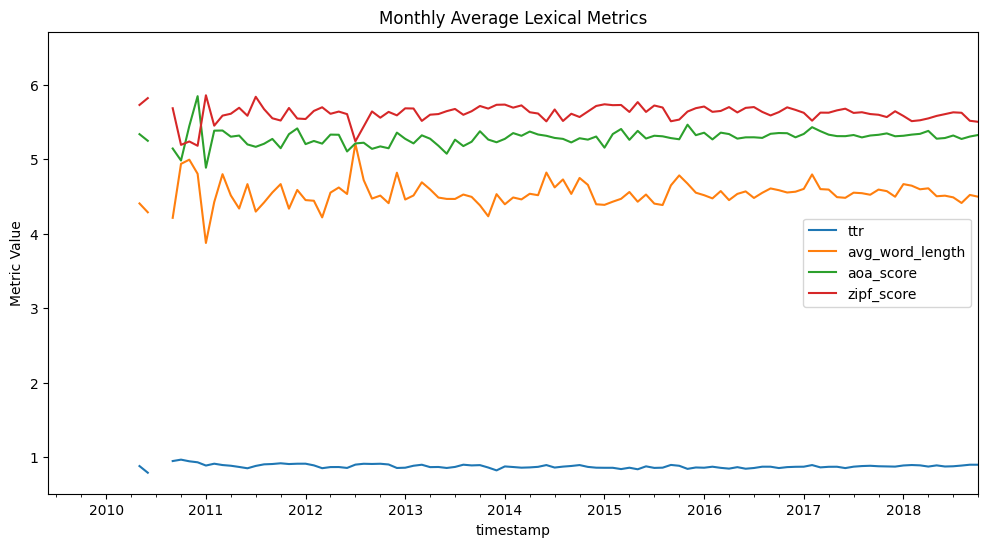

In [104]:
monthly_metrics.plot(figsize=(12,6), title='Monthly Average Lexical Metrics')
plt.ylabel('Metric Value')
plt.show()